In [2]:
pip install torchinfo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


import torch
from torch import nn
import torchvision
from torchvision import transforms
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

In [4]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [5]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [6]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [7]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)


In [8]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [28]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        y = y.float()

        # 1. Forward pass
        y_pred = model(X).squeeze()

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        # turn logits -> pred probs -> pred labls

        # Calculate and accumulate accuracy metric across all batches
        # torch.eq() calculates where two tensors are equal
        correct = torch.eq(y, torch.round(torch.sigmoid(y_pred))).sum().item()
        train_acc += (correct / len(y)) * 100
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            y = y.float()
            # 1. Forward pass
            test_pred_logits = model(X).squeeze()
            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            # Calculate and accumulate accuracy
            correct = torch.eq(y, torch.round(torch.sigmoid(test_pred_logits))).sum(
            ).item()  # torch.eq() calculates where two tensors are equal
            test_acc += (correct / len(y)) * 100

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if ((epoch == 5) or (epoch == 10)):
          save_filepath = f"lr001_ownCNN_100percent_{epoch + 30}_epochs.pth"
          save_model(model=model,
                        target_dir="models",
                        model_name=save_filepath)
        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)

        # Track the PyTorch model architecture
        writer.add_graph(model=model,
                         # Pass in an example input
                         input_to_model=torch.randn(16, 1, 224, 224).to(device))

    # Close the writer
    writer.close()


    # Return the filled results at the end of the epochs
    return results


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [14]:
from numpy.core.fromnumeric import resize
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation

                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1),antialias=True)

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])


In [15]:
train_dataset = torchvision.datasets.DatasetFolder(
    '/content/drive/MyDrive/pneumonia-detection/Processed/train/',
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    '/content/drive/MyDrive/pneumonia-detection/Processed/val/',
    loader=load_file, extensions="npy", transform=val_transforms)


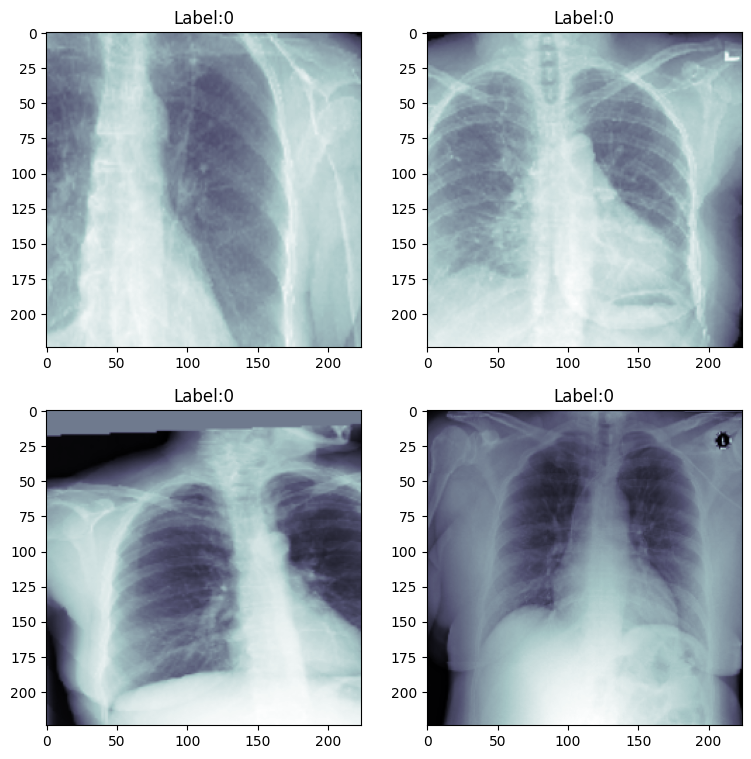

In [16]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 100)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")



In [17]:
batch_size = 64#TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,num_workers=8,  shuffle=True,drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=8,   shuffle=False,drop_last=True)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

In [22]:
# Create a convolutional neural network
class PnemoniaDetectionModel(nn.Module):
    """
    Model architecture copying based on TinyVGG:

    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*56*56,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(x.shape)
        x = self.block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x




In [23]:
torch.manual_seed(42)
model = PnemoniaDetectionModel(input_shape=1,
    hidden_units=10,
    output_shape=1).to(device)
model

PnemoniaDetectionModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=1, bias=True)
  )
)

In [24]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(64, 1, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
PnemoniaDetectionModel (PnemoniaDetectionModel)    [64, 1, 224, 224]    [64, 1]              --                   True
├─Sequential (block_1)                             [64, 1, 224, 224]    [64, 10, 112, 112]   --                   True
│    └─Conv2d (0)                                  [64, 1, 224, 224]    [64, 10, 224, 224]   100                  True
│    └─ReLU (1)                                    [64, 10, 224, 224]   [64, 10, 224, 224]   --                   --
│    └─Conv2d (2)                                  [64, 10, 224, 224]   [64, 10, 224, 224]   910                  True
│    └─ReLU (3)                                    [64, 10, 224, 224]   [64, 10, 224, 224]   --                   --
│    └─MaxPool2d (4)                               [64, 10, 224, 224]   [64, 10, 112, 112]   --                   --
├─Sequential (block_2)                           

In [25]:
print(model)

PnemoniaDetectionModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=1, bias=True)
  )
)


In [26]:
# 1. Create epochs list
num_epochs = [30]
models = ["OwnCNN"]
train_dataloaders = {"100_Percent_Training_Images": train_loader}


In [27]:
%%time


# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs:

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")



            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]).to(device))
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

            # 9. Train target model with target dataloaders and track experiments
            results = train(model=model,
                  train_dataloader=train_loader,
                  test_dataloader=val_loader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

            # 10. Save the model to file so we can get back the best model
            save_filepath = f"posweight3lr0001_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: OwnCNN
[INFO] DataLoader: 100_Percent_Training_Images
[INFO] Number of epochs: 30
[INFO] Created SummaryWriter, saving to: runs/2023-09-27/100_Percent_Training_Images/OwnCNN/30_epochs...


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 | train_loss: 0.9300 | train_acc: 69.9792 | test_loss: 0.8189 | test_acc: 70.5793
Epoch: 2 | train_loss: 0.8690 | train_acc: 70.0042 | test_loss: 0.8042 | test_acc: 71.8750
Epoch: 3 | train_loss: 0.8649 | train_acc: 70.3625 | test_loss: 0.8458 | test_acc: 62.3857
Epoch: 4 | train_loss: 0.8632 | train_acc: 70.3792 | test_loss: 0.7926 | test_acc: 74.4665
Epoch: 5 | train_loss: 0.8544 | train_acc: 70.8958 | test_loss: 0.7931 | test_acc: 72.4848
Epoch: 6 | train_loss: 0.8531 | train_acc: 71.1583 | test_loss: 0.8380 | test_acc: 62.9192
[INFO] Saving model to: models/lr001_ownCNN_100percent_5_epochs.pth
Epoch: 7 | train_loss: 0.8436 | train_acc: 71.6083 | test_loss: 0.7817 | test_acc: 76.2957
Epoch: 8 | train_loss: 0.8443 | train_acc: 71.4833 | test_loss: 0.8007 | test_acc: 67.1875
Epoch: 9 | train_loss: 0.8375 | train_acc: 71.5958 | test_loss: 0.7964 | test_acc: 67.4543
Epoch: 10 | train_loss: 0.8362 | train_acc: 71.8667 | test_loss: 0.7887 | test_acc: 68.3689
Epoch: 11 | train_los

In [29]:
%%time


# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs:

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")



            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]).to(device))
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

            # 9. Train target model with target dataloaders and track experiments
            results = train(model=model,
                  train_dataloader=train_loader,
                  test_dataloader=val_loader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

            # 10. Save the model to file so we can get back the best model
            save_filepath = f"posweight3lr0001_{model_name}_{dataloader_name}_60_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: OwnCNN
[INFO] DataLoader: 100_Percent_Training_Images
[INFO] Number of epochs: 30
[INFO] Created SummaryWriter, saving to: runs/2023-09-27/100_Percent_Training_Images/OwnCNN/30_epochs...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8054 | train_acc: 73.3542 | test_loss: 0.7338 | test_acc: 75.8384
Epoch: 2 | train_loss: 0.8077 | train_acc: 73.0750 | test_loss: 0.7503 | test_acc: 71.7988
Epoch: 3 | train_loss: 0.8040 | train_acc: 73.1958 | test_loss: 0.7884 | test_acc: 67.5305
Epoch: 4 | train_loss: 0.8073 | train_acc: 73.2708 | test_loss: 0.7345 | test_acc: 75.4954
Epoch: 5 | train_loss: 0.8045 | train_acc: 73.1625 | test_loss: 0.7446 | test_acc: 72.4848
Epoch: 6 | train_loss: 0.8042 | train_acc: 73.2708 | test_loss: 0.7795 | test_acc: 68.1784
[INFO] Saving model to: models/lr001_ownCNN_100percent_35_epochs.pth
Epoch: 7 | train_loss: 0.8014 | train_acc: 73.3208 | test_loss: 0.7264 | test_acc: 76.4863
Epoch: 8 | train_loss: 0.8055 | train_acc: 73.1417 | test_loss: 0.7577 | test_acc: 70.9985
Epoch: 9 | train_loss: 0.7972 | train_acc: 73.5708 | test_loss: 0.7503 | test_acc: 71.4939
Epoch: 10 | train_loss: 0.8020 | train_acc: 73.3750 | test_loss: 0.7439 | test_acc: 72.4085
Epoch: 11 | train_lo

In [30]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

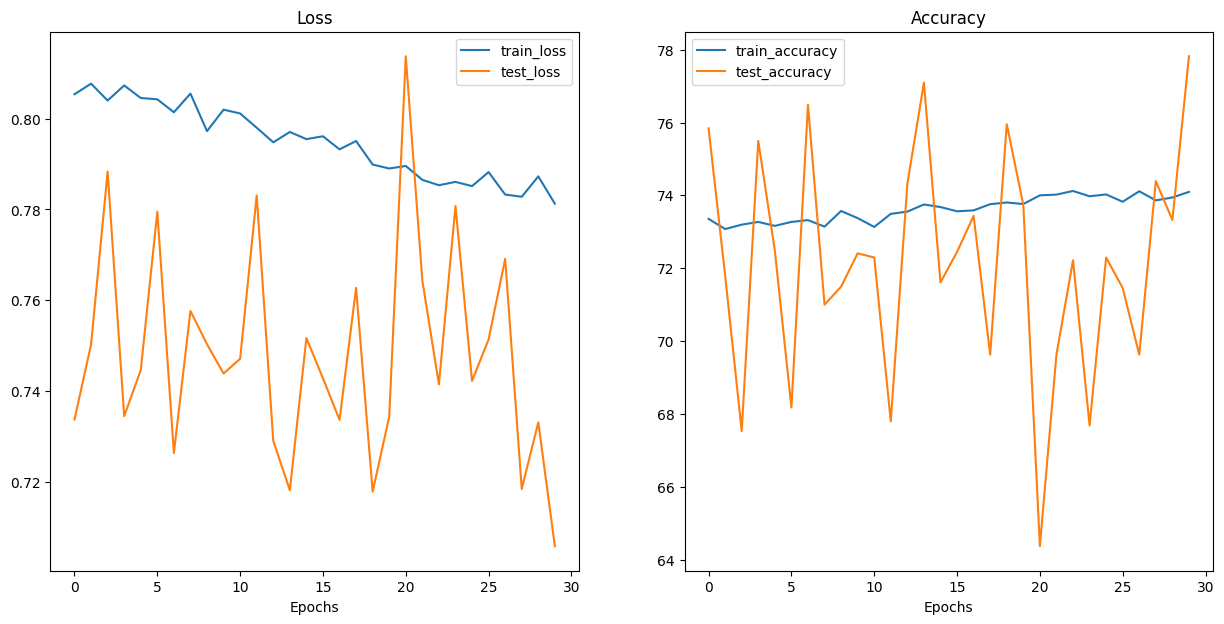

In [31]:
plot_loss_curves(results)

In [33]:
from torch import nn
import torchvision
from pathlib import Path
MODEL_PATH = Path("models/")
MODEL_NAME = "posweight3lr0001_OwnCNN_100_Percent_Training_Images_30_epochs.pth"
# 2. Create model save path
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Create a ResNet50 model.
loaded_model = PnemoniaDetectionModel(input_shape=1,
    hidden_units=10,
    output_shape=1)


loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH,map_location=device))


# Set the model to evaluation mode.
loaded_model.eval()
loaded_model.to(device);

cuda:0


In [34]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(loaded_model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [35]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.1 MB/s eta 0:00:00


In [36]:
import torchmetrics

acc = torchmetrics.Accuracy(task='binary', threshold=0.5)(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary')(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task='binary', threshold=0.5)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.7742176055908203
Val Precision: 0.49944010376930237
Val Recall: 0.7371900677680969
Confusion Matrix:
 tensor([[1632,  447],
        [ 159,  446]])
Confusion Matrix 2:
 tensor([[1632,  447],
        [ 159,  446]])


In [37]:
F1 = 2 * (precision * recall) / (precision + recall)

print(F1)

tensor(0.5955)


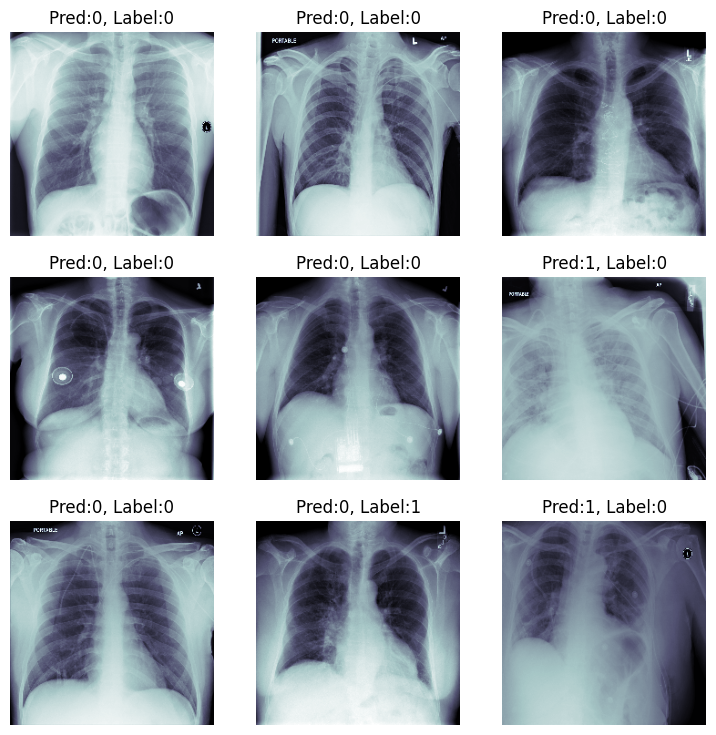

In [38]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")

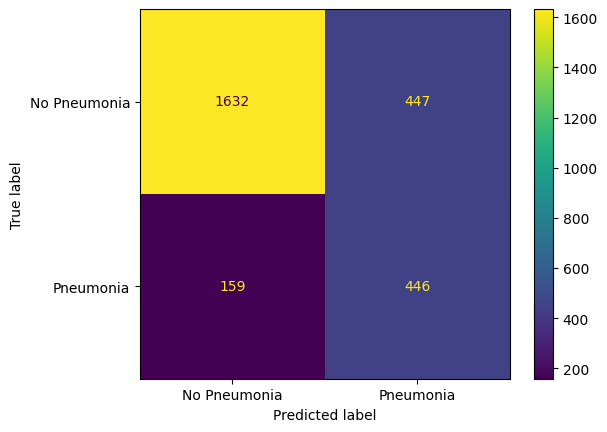

In [39]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
y_preds = torch.round(preds)
ConfusionMatrixDisplay.from_predictions(
    y_pred=y_preds, y_true=labels, display_labels=["No Pneumonia", "Pneumonia"])
plt.show()